In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

    # Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/home/ashwin/anaconda3/envs/ViTPicker/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [4]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

# Set the batch size
BATCH_SIZE = 15 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders  this file(datasetup.py) is inside going modular folder
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x7f3797db5ad0>,
 ['pizza', 'steak', 'sushi'])

In [5]:
len(train_dataloader), len(test_dataloader), len (class_names)

(15, 5, 3)

In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

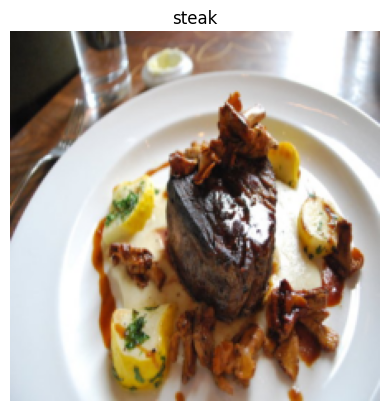

In [7]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [8]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables, parameters from table 1
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [9]:
class ViT(nn.Module): 
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1  (remains same in the entire architecture)
               dropout=0.1, 
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size 
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding (import from the class built earlier)
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token (*s in the diagram)
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)  #true means pytorch tracks and updates gradient, hence learnable

    # 3. Create positional embedding (to keep track of where the patch of image belong to)
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2 formula from paper
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    #not shown in figure 1
    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head  (from eq 4)
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    #this is the rectangular portion of paper
    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    #up arrows in figure 1
    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [10]:
vit = ViT().to(device)
vit

ViT(
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
     

In [11]:
summary(model=vit)

Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─PatchEmbedding: 1-1                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Dropout: 1-2                                                    --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          7,087,872
│    │    └─TransformerEncoderLayer: 3-2                          7,087,872
│    │    └─TransformerEncoderLayer: 3-3                          7,087,872
│    │    └─TransformerEncoderLayer: 3-4                          7,087,872
│    │    └─TransformerEncoderLayer: 3-5                          7,087,872
│    │    └─TransformerEncoderLayer: 3-6             

In [12]:
# Train ViT
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1000, #10 here
                       device=device)  #device = cuda while defining



  0%|▏                                                                                                                                                                          | 1/1000 [00:07<2:02:16,  7.34s/it]

Epoch: 1 | train_loss: 2.5008 | train_acc: 0.2844 | test_loss: 1.7623 | test_acc: 0.3333


  0%|▎                                                                                                                                                                          | 2/1000 [00:13<1:52:45,  6.78s/it]

Epoch: 2 | train_loss: 1.4542 | train_acc: 0.3378 | test_loss: 1.2578 | test_acc: 0.2400


  0%|▌                                                                                                                                                                          | 3/1000 [00:20<1:49:25,  6.59s/it]

Epoch: 3 | train_loss: 1.2235 | train_acc: 0.3333 | test_loss: 1.1205 | test_acc: 0.4133


  0%|▋                                                                                                                                                                          | 4/1000 [00:26<1:48:04,  6.51s/it]

Epoch: 4 | train_loss: 1.1873 | train_acc: 0.2711 | test_loss: 1.1454 | test_acc: 0.3333


  0%|▊                                                                                                                                                                          | 5/1000 [00:32<1:47:19,  6.47s/it]

Epoch: 5 | train_loss: 1.1769 | train_acc: 0.3289 | test_loss: 1.1307 | test_acc: 0.3333


  1%|█                                                                                                                                                                          | 6/1000 [00:39<1:47:01,  6.46s/it]

Epoch: 6 | train_loss: 1.2079 | train_acc: 0.2533 | test_loss: 1.1262 | test_acc: 0.4133


  1%|█▏                                                                                                                                                                         | 7/1000 [00:45<1:47:08,  6.47s/it]

Epoch: 7 | train_loss: 1.2108 | train_acc: 0.2978 | test_loss: 1.1690 | test_acc: 0.2533


  1%|█▎                                                                                                                                                                         | 8/1000 [00:52<1:47:22,  6.49s/it]

Epoch: 8 | train_loss: 1.1845 | train_acc: 0.3556 | test_loss: 1.1310 | test_acc: 0.3333


  1%|█▌                                                                                                                                                                         | 9/1000 [00:58<1:47:37,  6.52s/it]

Epoch: 9 | train_loss: 1.1793 | train_acc: 0.3378 | test_loss: 1.1218 | test_acc: 0.3333


  1%|█▋                                                                                                                                                                        | 10/1000 [01:05<1:47:44,  6.53s/it]

Epoch: 10 | train_loss: 1.2077 | train_acc: 0.3556 | test_loss: 1.2078 | test_acc: 0.3333


  1%|█▊                                                                                                                                                                        | 11/1000 [01:12<1:47:53,  6.55s/it]

Epoch: 11 | train_loss: 1.2105 | train_acc: 0.3067 | test_loss: 1.2055 | test_acc: 0.2533


  1%|██                                                                                                                                                                        | 12/1000 [01:18<1:48:07,  6.57s/it]

Epoch: 12 | train_loss: 1.2467 | train_acc: 0.2844 | test_loss: 1.2528 | test_acc: 0.2533


  1%|██▏                                                                                                                                                                       | 13/1000 [01:25<1:48:19,  6.58s/it]

Epoch: 13 | train_loss: 1.2290 | train_acc: 0.3289 | test_loss: 1.3695 | test_acc: 0.3333


  1%|██▍                                                                                                                                                                       | 14/1000 [01:31<1:48:37,  6.61s/it]

Epoch: 14 | train_loss: 1.2262 | train_acc: 0.3600 | test_loss: 1.1455 | test_acc: 0.4133


  2%|██▌                                                                                                                                                                       | 15/1000 [01:38<1:48:54,  6.63s/it]

Epoch: 15 | train_loss: 1.2276 | train_acc: 0.3378 | test_loss: 1.2070 | test_acc: 0.2533


  2%|██▋                                                                                                                                                                       | 16/1000 [01:45<1:49:04,  6.65s/it]

Epoch: 16 | train_loss: 1.2411 | train_acc: 0.3244 | test_loss: 1.2062 | test_acc: 0.3333


  2%|██▉                                                                                                                                                                       | 17/1000 [01:52<1:49:02,  6.66s/it]

Epoch: 17 | train_loss: 1.2380 | train_acc: 0.3333 | test_loss: 1.1732 | test_acc: 0.4133


  2%|███                                                                                                                                                                       | 18/1000 [01:58<1:49:08,  6.67s/it]

Epoch: 18 | train_loss: 1.2335 | train_acc: 0.3244 | test_loss: 1.2173 | test_acc: 0.3333


  2%|███▏                                                                                                                                                                      | 19/1000 [02:05<1:49:00,  6.67s/it]

Epoch: 19 | train_loss: 1.2597 | train_acc: 0.2933 | test_loss: 1.1892 | test_acc: 0.4133


  2%|███▍                                                                                                                                                                      | 20/1000 [02:12<1:49:07,  6.68s/it]

Epoch: 20 | train_loss: 1.2655 | train_acc: 0.3111 | test_loss: 1.2376 | test_acc: 0.3333


  2%|███▌                                                                                                                                                                      | 21/1000 [02:18<1:48:59,  6.68s/it]

Epoch: 21 | train_loss: 1.2908 | train_acc: 0.3111 | test_loss: 1.2167 | test_acc: 0.3333


  2%|███▋                                                                                                                                                                      | 22/1000 [02:25<1:49:13,  6.70s/it]

Epoch: 22 | train_loss: 1.3126 | train_acc: 0.3467 | test_loss: 1.2529 | test_acc: 0.2533


  2%|███▉                                                                                                                                                                      | 23/1000 [02:32<1:48:58,  6.69s/it]

Epoch: 23 | train_loss: 1.3185 | train_acc: 0.3111 | test_loss: 1.2447 | test_acc: 0.4133


  2%|████                                                                                                                                                                      | 24/1000 [02:38<1:49:01,  6.70s/it]

Epoch: 24 | train_loss: 1.3188 | train_acc: 0.3467 | test_loss: 1.2720 | test_acc: 0.3333


  2%|████▎                                                                                                                                                                     | 25/1000 [02:45<1:48:52,  6.70s/it]

Epoch: 25 | train_loss: 1.3244 | train_acc: 0.2933 | test_loss: 1.2593 | test_acc: 0.4133


  3%|████▍                                                                                                                                                                     | 26/1000 [02:52<1:48:35,  6.69s/it]

Epoch: 26 | train_loss: 1.3354 | train_acc: 0.3333 | test_loss: 1.3017 | test_acc: 0.3333


  3%|████▌                                                                                                                                                                     | 27/1000 [02:58<1:48:34,  6.70s/it]

Epoch: 27 | train_loss: 1.3394 | train_acc: 0.2933 | test_loss: 1.2664 | test_acc: 0.4133


  3%|████▊                                                                                                                                                                     | 28/1000 [03:05<1:48:36,  6.70s/it]

Epoch: 28 | train_loss: 1.3341 | train_acc: 0.3289 | test_loss: 1.2752 | test_acc: 0.3333


  3%|████▉                                                                                                                                                                     | 29/1000 [03:12<1:48:33,  6.71s/it]

Epoch: 29 | train_loss: 1.3331 | train_acc: 0.3422 | test_loss: 1.2698 | test_acc: 0.3333


  3%|█████                                                                                                                                                                     | 30/1000 [03:19<1:48:28,  6.71s/it]

Epoch: 30 | train_loss: 1.3442 | train_acc: 0.2844 | test_loss: 1.2634 | test_acc: 0.3333


  3%|█████▎                                                                                                                                                                    | 31/1000 [03:25<1:48:22,  6.71s/it]

Epoch: 31 | train_loss: 1.3171 | train_acc: 0.3422 | test_loss: 1.2567 | test_acc: 0.2533


  3%|█████▍                                                                                                                                                                    | 32/1000 [03:32<1:48:08,  6.70s/it]

Epoch: 32 | train_loss: 1.2952 | train_acc: 0.3067 | test_loss: 1.2141 | test_acc: 0.4133


  3%|█████▌                                                                                                                                                                    | 33/1000 [03:39<1:47:54,  6.70s/it]

Epoch: 33 | train_loss: 1.2620 | train_acc: 0.3333 | test_loss: 1.2214 | test_acc: 0.2533


  3%|█████▊                                                                                                                                                                    | 34/1000 [03:45<1:47:55,  6.70s/it]

Epoch: 34 | train_loss: 1.2499 | train_acc: 0.3378 | test_loss: 1.1773 | test_acc: 0.3333


  4%|█████▉                                                                                                                                                                    | 35/1000 [03:52<1:47:52,  6.71s/it]

Epoch: 35 | train_loss: 1.2205 | train_acc: 0.2978 | test_loss: 1.1648 | test_acc: 0.2533


  4%|██████                                                                                                                                                                    | 36/1000 [03:59<1:47:46,  6.71s/it]

Epoch: 36 | train_loss: 1.2184 | train_acc: 0.3244 | test_loss: 1.1444 | test_acc: 0.3333


  4%|██████▎                                                                                                                                                                   | 37/1000 [04:06<1:47:48,  6.72s/it]

Epoch: 37 | train_loss: 1.1893 | train_acc: 0.3467 | test_loss: 1.1432 | test_acc: 0.3333


  4%|██████▍                                                                                                                                                                   | 38/1000 [04:12<1:47:39,  6.71s/it]

Epoch: 38 | train_loss: 1.2006 | train_acc: 0.3022 | test_loss: 1.1461 | test_acc: 0.2533


  4%|██████▋                                                                                                                                                                   | 39/1000 [04:19<1:47:37,  6.72s/it]

Epoch: 39 | train_loss: 1.1856 | train_acc: 0.3289 | test_loss: 1.1281 | test_acc: 0.3333


  4%|██████▊                                                                                                                                                                   | 40/1000 [04:26<1:47:27,  6.72s/it]

Epoch: 40 | train_loss: 1.1737 | train_acc: 0.3333 | test_loss: 1.1321 | test_acc: 0.4133


  4%|██████▉                                                                                                                                                                   | 41/1000 [04:32<1:47:23,  6.72s/it]

Epoch: 41 | train_loss: 1.1818 | train_acc: 0.3378 | test_loss: 1.1311 | test_acc: 0.3333


  4%|███████▏                                                                                                                                                                  | 42/1000 [04:39<1:47:18,  6.72s/it]

Epoch: 42 | train_loss: 1.1799 | train_acc: 0.3422 | test_loss: 1.1293 | test_acc: 0.2533


  4%|███████▎                                                                                                                                                                  | 43/1000 [04:46<1:47:13,  6.72s/it]

Epoch: 43 | train_loss: 1.1808 | train_acc: 0.3067 | test_loss: 1.1104 | test_acc: 0.3333


  4%|███████▍                                                                                                                                                                  | 44/1000 [04:53<1:47:18,  6.73s/it]

Epoch: 44 | train_loss: 1.1681 | train_acc: 0.3467 | test_loss: 1.1171 | test_acc: 0.3333


  4%|███████▋                                                                                                                                                                  | 45/1000 [04:59<1:47:16,  6.74s/it]

Epoch: 45 | train_loss: 1.1577 | train_acc: 0.3244 | test_loss: 1.1369 | test_acc: 0.3333


  5%|███████▊                                                                                                                                                                  | 46/1000 [05:06<1:47:12,  6.74s/it]

Epoch: 46 | train_loss: 1.1558 | train_acc: 0.3467 | test_loss: 1.1284 | test_acc: 0.3333


  5%|███████▉                                                                                                                                                                  | 47/1000 [05:13<1:46:50,  6.73s/it]

Epoch: 47 | train_loss: 1.1650 | train_acc: 0.3289 | test_loss: 1.1201 | test_acc: 0.2533


  5%|████████▏                                                                                                                                                                 | 48/1000 [05:20<1:46:55,  6.74s/it]

Epoch: 48 | train_loss: 1.1506 | train_acc: 0.3333 | test_loss: 1.1303 | test_acc: 0.2533


  5%|████████▎                                                                                                                                                                 | 49/1000 [05:26<1:46:56,  6.75s/it]

Epoch: 49 | train_loss: 1.1514 | train_acc: 0.2933 | test_loss: 1.1078 | test_acc: 0.3333


  5%|████████▌                                                                                                                                                                 | 50/1000 [05:33<1:46:56,  6.75s/it]

Epoch: 50 | train_loss: 1.1435 | train_acc: 0.3467 | test_loss: 1.1048 | test_acc: 0.3333


  5%|████████▋                                                                                                                                                                 | 51/1000 [05:40<1:46:47,  6.75s/it]

Epoch: 51 | train_loss: 1.1445 | train_acc: 0.3467 | test_loss: 1.1145 | test_acc: 0.2533


  5%|████████▊                                                                                                                                                                 | 52/1000 [05:47<1:46:39,  6.75s/it]

Epoch: 52 | train_loss: 1.1354 | train_acc: 0.3333 | test_loss: 1.1330 | test_acc: 0.2533


  5%|█████████                                                                                                                                                                 | 53/1000 [05:53<1:46:36,  6.75s/it]

Epoch: 53 | train_loss: 1.1444 | train_acc: 0.3200 | test_loss: 1.1233 | test_acc: 0.2533


  5%|█████████▏                                                                                                                                                                | 54/1000 [06:00<1:46:31,  6.76s/it]

Epoch: 54 | train_loss: 1.1509 | train_acc: 0.2978 | test_loss: 1.1085 | test_acc: 0.3333


  6%|█████████▎                                                                                                                                                                | 55/1000 [06:07<1:46:30,  6.76s/it]

Epoch: 55 | train_loss: 1.1413 | train_acc: 0.3289 | test_loss: 1.1390 | test_acc: 0.2533


  6%|█████████▌                                                                                                                                                                | 56/1000 [06:14<1:46:30,  6.77s/it]

Epoch: 56 | train_loss: 1.1441 | train_acc: 0.3378 | test_loss: 1.1050 | test_acc: 0.3333


  6%|█████████▋                                                                                                                                                                | 57/1000 [06:21<1:46:20,  6.77s/it]

Epoch: 57 | train_loss: 1.1325 | train_acc: 0.3067 | test_loss: 1.1220 | test_acc: 0.2533


  6%|█████████▊                                                                                                                                                                | 58/1000 [06:27<1:46:20,  6.77s/it]

Epoch: 58 | train_loss: 1.1362 | train_acc: 0.2933 | test_loss: 1.1266 | test_acc: 0.2533


  6%|██████████                                                                                                                                                                | 59/1000 [06:34<1:46:18,  6.78s/it]

Epoch: 59 | train_loss: 1.1393 | train_acc: 0.3244 | test_loss: 1.1101 | test_acc: 0.3333


  6%|██████████▏                                                                                                                                                               | 60/1000 [06:41<1:46:33,  6.80s/it]

Epoch: 60 | train_loss: 1.1394 | train_acc: 0.3467 | test_loss: 1.1202 | test_acc: 0.3333


  6%|██████████▎                                                                                                                                                               | 61/1000 [06:48<1:46:13,  6.79s/it]

Epoch: 61 | train_loss: 1.1476 | train_acc: 0.2978 | test_loss: 1.1121 | test_acc: 0.4133


  6%|██████████▌                                                                                                                                                               | 62/1000 [06:54<1:45:55,  6.78s/it]

Epoch: 62 | train_loss: 1.1465 | train_acc: 0.3289 | test_loss: 1.1192 | test_acc: 0.3333


  6%|██████████▋                                                                                                                                                               | 63/1000 [07:01<1:45:45,  6.77s/it]

Epoch: 63 | train_loss: 1.1359 | train_acc: 0.3200 | test_loss: 1.1242 | test_acc: 0.2533


  6%|██████████▉                                                                                                                                                               | 64/1000 [07:08<1:45:39,  6.77s/it]

Epoch: 64 | train_loss: 1.1401 | train_acc: 0.3244 | test_loss: 1.1307 | test_acc: 0.2533


  6%|███████████                                                                                                                                                               | 65/1000 [07:15<1:45:44,  6.79s/it]

Epoch: 65 | train_loss: 1.1258 | train_acc: 0.3422 | test_loss: 1.1007 | test_acc: 0.3333


  7%|███████████▏                                                                                                                                                              | 66/1000 [07:22<1:45:32,  6.78s/it]

Epoch: 66 | train_loss: 1.1342 | train_acc: 0.2711 | test_loss: 1.1275 | test_acc: 0.2533


  7%|███████████▍                                                                                                                                                              | 67/1000 [07:28<1:45:17,  6.77s/it]

Epoch: 67 | train_loss: 1.1265 | train_acc: 0.3244 | test_loss: 1.1115 | test_acc: 0.3333


  7%|███████████▌                                                                                                                                                              | 68/1000 [07:35<1:45:22,  6.78s/it]

Epoch: 68 | train_loss: 1.1315 | train_acc: 0.3467 | test_loss: 1.1101 | test_acc: 0.3333


  7%|███████████▋                                                                                                                                                              | 69/1000 [07:42<1:45:30,  6.80s/it]

Epoch: 69 | train_loss: 1.1302 | train_acc: 0.3200 | test_loss: 1.1205 | test_acc: 0.2533


  7%|███████████▉                                                                                                                                                              | 70/1000 [07:49<1:45:35,  6.81s/it]

Epoch: 70 | train_loss: 1.1254 | train_acc: 0.3244 | test_loss: 1.1147 | test_acc: 0.3333


  7%|████████████                                                                                                                                                              | 71/1000 [07:56<1:45:32,  6.82s/it]

Epoch: 71 | train_loss: 1.1309 | train_acc: 0.3067 | test_loss: 1.1084 | test_acc: 0.4133


  7%|████████████▏                                                                                                                                                             | 72/1000 [08:02<1:45:29,  6.82s/it]

Epoch: 72 | train_loss: 1.1225 | train_acc: 0.3289 | test_loss: 1.1240 | test_acc: 0.3333


  7%|████████████▍                                                                                                                                                             | 73/1000 [08:09<1:45:19,  6.82s/it]

Epoch: 73 | train_loss: 1.1387 | train_acc: 0.3422 | test_loss: 1.1142 | test_acc: 0.3333


  7%|████████████▌                                                                                                                                                             | 74/1000 [08:16<1:45:29,  6.83s/it]

Epoch: 74 | train_loss: 1.1249 | train_acc: 0.3067 | test_loss: 1.1135 | test_acc: 0.2533


  8%|████████████▊                                                                                                                                                             | 75/1000 [08:23<1:45:27,  6.84s/it]

Epoch: 75 | train_loss: 1.1329 | train_acc: 0.3289 | test_loss: 1.1179 | test_acc: 0.3333


  8%|████████████▉                                                                                                                                                             | 76/1000 [08:30<1:45:19,  6.84s/it]

Epoch: 76 | train_loss: 1.1211 | train_acc: 0.3378 | test_loss: 1.1209 | test_acc: 0.2533


  8%|█████████████                                                                                                                                                             | 77/1000 [08:37<1:45:04,  6.83s/it]

Epoch: 77 | train_loss: 1.1318 | train_acc: 0.2800 | test_loss: 1.1102 | test_acc: 0.4133


  8%|█████████████▎                                                                                                                                                            | 78/1000 [08:43<1:44:50,  6.82s/it]

Epoch: 78 | train_loss: 1.1224 | train_acc: 0.3200 | test_loss: 1.1269 | test_acc: 0.3333


  8%|█████████████▍                                                                                                                                                            | 79/1000 [08:50<1:44:44,  6.82s/it]

Epoch: 79 | train_loss: 1.1283 | train_acc: 0.3156 | test_loss: 1.1131 | test_acc: 0.2533


  8%|█████████████▌                                                                                                                                                            | 80/1000 [08:57<1:44:46,  6.83s/it]

Epoch: 80 | train_loss: 1.1254 | train_acc: 0.2800 | test_loss: 1.1255 | test_acc: 0.2533


  8%|█████████████▊                                                                                                                                                            | 81/1000 [09:04<1:45:24,  6.88s/it]

Epoch: 81 | train_loss: 1.1218 | train_acc: 0.3467 | test_loss: 1.1240 | test_acc: 0.3333


  8%|█████████████▉                                                                                                                                                            | 82/1000 [09:11<1:44:55,  6.86s/it]

Epoch: 82 | train_loss: 1.1275 | train_acc: 0.2889 | test_loss: 1.1122 | test_acc: 0.3333


  8%|██████████████                                                                                                                                                            | 83/1000 [09:18<1:44:31,  6.84s/it]

Epoch: 83 | train_loss: 1.1227 | train_acc: 0.3422 | test_loss: 1.1201 | test_acc: 0.2533


  8%|██████████████▎                                                                                                                                                           | 84/1000 [09:25<1:44:22,  6.84s/it]

Epoch: 84 | train_loss: 1.1246 | train_acc: 0.2978 | test_loss: 1.1157 | test_acc: 0.2533


  8%|██████████████▍                                                                                                                                                           | 85/1000 [09:31<1:44:15,  6.84s/it]

Epoch: 85 | train_loss: 1.1259 | train_acc: 0.3333 | test_loss: 1.1256 | test_acc: 0.3333


  9%|██████████████▌                                                                                                                                                           | 86/1000 [09:38<1:44:24,  6.85s/it]

Epoch: 86 | train_loss: 1.1289 | train_acc: 0.3467 | test_loss: 1.1078 | test_acc: 0.3333


  9%|██████████████▊                                                                                                                                                           | 87/1000 [09:45<1:44:25,  6.86s/it]

Epoch: 87 | train_loss: 1.1265 | train_acc: 0.3244 | test_loss: 1.1350 | test_acc: 0.2533


  9%|██████████████▉                                                                                                                                                           | 88/1000 [09:52<1:45:01,  6.91s/it]

Epoch: 88 | train_loss: 1.1267 | train_acc: 0.3111 | test_loss: 1.1134 | test_acc: 0.3333


  9%|███████████████▏                                                                                                                                                          | 89/1000 [09:59<1:44:21,  6.87s/it]

Epoch: 89 | train_loss: 1.1229 | train_acc: 0.3111 | test_loss: 1.1150 | test_acc: 0.3333


  9%|███████████████▎                                                                                                                                                          | 90/1000 [10:06<1:43:58,  6.86s/it]

Epoch: 90 | train_loss: 1.1212 | train_acc: 0.3200 | test_loss: 1.1328 | test_acc: 0.2533


  9%|███████████████▍                                                                                                                                                          | 91/1000 [10:13<1:43:46,  6.85s/it]

Epoch: 91 | train_loss: 1.1221 | train_acc: 0.3333 | test_loss: 1.1144 | test_acc: 0.3333


  9%|███████████████▋                                                                                                                                                          | 92/1000 [10:20<1:43:41,  6.85s/it]

Epoch: 92 | train_loss: 1.1191 | train_acc: 0.3467 | test_loss: 1.1132 | test_acc: 0.3333


  9%|███████████████▊                                                                                                                                                          | 93/1000 [10:26<1:43:36,  6.85s/it]

Epoch: 93 | train_loss: 1.1233 | train_acc: 0.3467 | test_loss: 1.1329 | test_acc: 0.3333


  9%|███████████████▉                                                                                                                                                          | 94/1000 [10:33<1:43:40,  6.87s/it]

Epoch: 94 | train_loss: 1.1232 | train_acc: 0.3244 | test_loss: 1.1186 | test_acc: 0.2533


 10%|████████████████▏                                                                                                                                                         | 95/1000 [10:40<1:43:42,  6.88s/it]

Epoch: 95 | train_loss: 1.1224 | train_acc: 0.3333 | test_loss: 1.1171 | test_acc: 0.2533


 10%|████████████████▎                                                                                                                                                         | 96/1000 [10:47<1:43:34,  6.87s/it]

Epoch: 96 | train_loss: 1.1226 | train_acc: 0.3200 | test_loss: 1.1249 | test_acc: 0.3333


 10%|████████████████▍                                                                                                                                                         | 97/1000 [10:54<1:43:20,  6.87s/it]

Epoch: 97 | train_loss: 1.1216 | train_acc: 0.3156 | test_loss: 1.1198 | test_acc: 0.2533


 10%|████████████████▋                                                                                                                                                         | 98/1000 [11:01<1:44:52,  6.98s/it]

Epoch: 98 | train_loss: 1.1243 | train_acc: 0.3289 | test_loss: 1.1199 | test_acc: 0.3333


 10%|████████████████▊                                                                                                                                                         | 99/1000 [11:08<1:44:50,  6.98s/it]

Epoch: 99 | train_loss: 1.1220 | train_acc: 0.2756 | test_loss: 1.1168 | test_acc: 0.3333


 10%|████████████████▉                                                                                                                                                        | 100/1000 [11:15<1:44:17,  6.95s/it]

Epoch: 100 | train_loss: 1.1215 | train_acc: 0.3467 | test_loss: 1.1182 | test_acc: 0.3333


 10%|█████████████████                                                                                                                                                        | 101/1000 [11:22<1:46:28,  7.11s/it]

Epoch: 101 | train_loss: 1.1401 | train_acc: 0.3422 | test_loss: 1.1239 | test_acc: 0.2533


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [11:29<1:45:14,  7.03s/it]

Epoch: 102 | train_loss: 1.1144 | train_acc: 0.3333 | test_loss: 1.1093 | test_acc: 0.3333


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [11:36<1:44:47,  7.01s/it]

Epoch: 103 | train_loss: 1.1155 | train_acc: 0.3244 | test_loss: 1.1311 | test_acc: 0.2533


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [11:43<1:43:53,  6.96s/it]

Epoch: 104 | train_loss: 1.1245 | train_acc: 0.3289 | test_loss: 1.1159 | test_acc: 0.3333


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [11:50<1:43:06,  6.91s/it]

Epoch: 105 | train_loss: 1.1228 | train_acc: 0.3289 | test_loss: 1.1258 | test_acc: 0.2533


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [11:57<1:42:40,  6.89s/it]

Epoch: 106 | train_loss: 1.1208 | train_acc: 0.3289 | test_loss: 1.1301 | test_acc: 0.3333


 11%|██████████████████                                                                                                                                                       | 107/1000 [12:04<1:42:18,  6.87s/it]

Epoch: 107 | train_loss: 1.1226 | train_acc: 0.3467 | test_loss: 1.1166 | test_acc: 0.3333


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [12:10<1:42:20,  6.88s/it]

Epoch: 108 | train_loss: 1.1233 | train_acc: 0.2889 | test_loss: 1.1301 | test_acc: 0.2533


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [12:17<1:42:22,  6.89s/it]

Epoch: 109 | train_loss: 1.1308 | train_acc: 0.2622 | test_loss: 1.1132 | test_acc: 0.3333


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [12:24<1:42:53,  6.94s/it]

Epoch: 110 | train_loss: 1.1248 | train_acc: 0.3067 | test_loss: 1.1432 | test_acc: 0.2533


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [12:32<1:44:25,  7.05s/it]

Epoch: 111 | train_loss: 1.1229 | train_acc: 0.3778 | test_loss: 1.1156 | test_acc: 0.3333


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [12:39<1:44:26,  7.06s/it]

Epoch: 112 | train_loss: 1.1255 | train_acc: 0.3156 | test_loss: 1.1310 | test_acc: 0.2533


 11%|███████████████████                                                                                                                                                      | 113/1000 [12:46<1:44:03,  7.04s/it]

Epoch: 113 | train_loss: 1.1203 | train_acc: 0.3244 | test_loss: 1.1159 | test_acc: 0.3333


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [12:53<1:44:15,  7.06s/it]

Epoch: 114 | train_loss: 1.1264 | train_acc: 0.2800 | test_loss: 1.1241 | test_acc: 0.2533


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [13:00<1:43:12,  7.00s/it]

Epoch: 115 | train_loss: 1.1227 | train_acc: 0.3244 | test_loss: 1.1253 | test_acc: 0.3333


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [13:07<1:42:43,  6.97s/it]

Epoch: 116 | train_loss: 1.1229 | train_acc: 0.2711 | test_loss: 1.1218 | test_acc: 0.2533


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [13:14<1:44:03,  7.07s/it]

Epoch: 117 | train_loss: 1.1217 | train_acc: 0.2933 | test_loss: 1.1184 | test_acc: 0.3333


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [13:21<1:44:23,  7.10s/it]

Epoch: 118 | train_loss: 1.1219 | train_acc: 0.3467 | test_loss: 1.1163 | test_acc: 0.3333


 12%|████████████████████                                                                                                                                                     | 119/1000 [13:28<1:44:05,  7.09s/it]

Epoch: 119 | train_loss: 1.1213 | train_acc: 0.3244 | test_loss: 1.1234 | test_acc: 0.2533


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [13:35<1:44:27,  7.12s/it]

Epoch: 120 | train_loss: 1.1232 | train_acc: 0.2933 | test_loss: 1.1242 | test_acc: 0.2533


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [13:43<1:45:56,  7.23s/it]

Epoch: 121 | train_loss: 1.1225 | train_acc: 0.3378 | test_loss: 1.1097 | test_acc: 0.3333


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [13:51<1:48:00,  7.38s/it]

Epoch: 122 | train_loss: 1.1212 | train_acc: 0.3289 | test_loss: 1.1262 | test_acc: 0.3333


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [13:58<1:49:32,  7.49s/it]

Epoch: 123 | train_loss: 1.1231 | train_acc: 0.3156 | test_loss: 1.1231 | test_acc: 0.2533


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [14:06<1:51:03,  7.61s/it]

Epoch: 124 | train_loss: 1.1242 | train_acc: 0.3378 | test_loss: 1.1124 | test_acc: 0.3333


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [14:14<1:51:48,  7.67s/it]

Epoch: 125 | train_loss: 1.1242 | train_acc: 0.3600 | test_loss: 1.1314 | test_acc: 0.2533


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [14:22<1:52:42,  7.74s/it]

Epoch: 126 | train_loss: 1.1252 | train_acc: 0.3111 | test_loss: 1.1123 | test_acc: 0.3333


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [14:30<1:52:13,  7.71s/it]

Epoch: 127 | train_loss: 1.1283 | train_acc: 0.3200 | test_loss: 1.1381 | test_acc: 0.2533


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [14:37<1:51:25,  7.67s/it]

Epoch: 128 | train_loss: 1.1308 | train_acc: 0.3333 | test_loss: 1.1128 | test_acc: 0.3333


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [14:45<1:50:10,  7.59s/it]

Epoch: 129 | train_loss: 1.1193 | train_acc: 0.3467 | test_loss: 1.1263 | test_acc: 0.2533


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [14:52<1:50:03,  7.59s/it]

Epoch: 130 | train_loss: 1.1257 | train_acc: 0.2933 | test_loss: 1.1159 | test_acc: 0.3333


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [15:00<1:49:43,  7.58s/it]

Epoch: 131 | train_loss: 1.1248 | train_acc: 0.3244 | test_loss: 1.1379 | test_acc: 0.2533


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [15:07<1:48:50,  7.52s/it]

Epoch: 132 | train_loss: 1.1433 | train_acc: 0.2800 | test_loss: 1.1122 | test_acc: 0.4133


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [15:15<1:48:29,  7.51s/it]

Epoch: 133 | train_loss: 1.1144 | train_acc: 0.3600 | test_loss: 1.1233 | test_acc: 0.3333


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [15:22<1:48:15,  7.50s/it]

Epoch: 134 | train_loss: 1.1247 | train_acc: 0.3022 | test_loss: 1.1254 | test_acc: 0.2533


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [15:30<1:48:01,  7.49s/it]

Epoch: 135 | train_loss: 1.1210 | train_acc: 0.3556 | test_loss: 1.1256 | test_acc: 0.3333


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [15:37<1:47:36,  7.47s/it]

Epoch: 136 | train_loss: 1.3421 | train_acc: 0.3467 | test_loss: 1.1181 | test_acc: 0.3333


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [15:45<1:47:54,  7.50s/it]

Epoch: 137 | train_loss: 1.1193 | train_acc: 0.2756 | test_loss: 1.1063 | test_acc: 0.3333


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [15:52<1:48:46,  7.57s/it]

Epoch: 138 | train_loss: 1.1195 | train_acc: 0.3467 | test_loss: 1.1225 | test_acc: 0.3333


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [16:00<1:49:44,  7.65s/it]

Epoch: 139 | train_loss: 1.1166 | train_acc: 0.3422 | test_loss: 1.1110 | test_acc: 0.2533


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [16:08<1:50:25,  7.70s/it]

Epoch: 140 | train_loss: 1.1087 | train_acc: 0.3422 | test_loss: 1.1124 | test_acc: 0.3333


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [16:16<1:52:26,  7.85s/it]

Epoch: 141 | train_loss: 1.1202 | train_acc: 0.2800 | test_loss: 1.1148 | test_acc: 0.2533


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [16:24<1:51:31,  7.80s/it]

Epoch: 142 | train_loss: 1.1165 | train_acc: 0.3556 | test_loss: 1.1257 | test_acc: 0.3333


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [16:31<1:50:01,  7.70s/it]

Epoch: 143 | train_loss: 1.1229 | train_acc: 0.3467 | test_loss: 1.1206 | test_acc: 0.3333


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [16:39<1:49:50,  7.70s/it]

Epoch: 144 | train_loss: 1.1206 | train_acc: 0.3378 | test_loss: 1.1285 | test_acc: 0.3333


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [16:47<1:48:56,  7.65s/it]

Epoch: 145 | train_loss: 1.1266 | train_acc: 0.2889 | test_loss: 1.1132 | test_acc: 0.3333


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [16:54<1:48:57,  7.66s/it]

Epoch: 146 | train_loss: 1.1201 | train_acc: 0.3244 | test_loss: 1.1387 | test_acc: 0.2533


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [17:02<1:47:38,  7.57s/it]

Epoch: 147 | train_loss: 1.1249 | train_acc: 0.2978 | test_loss: 1.1226 | test_acc: 0.2533


 15%|█████████████████████████                                                                                                                                                | 148/1000 [17:09<1:46:56,  7.53s/it]

Epoch: 148 | train_loss: 1.1228 | train_acc: 0.2756 | test_loss: 1.1178 | test_acc: 0.3333


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [17:16<1:44:20,  7.36s/it]

Epoch: 149 | train_loss: 1.1207 | train_acc: 0.3333 | test_loss: 1.1310 | test_acc: 0.2533


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [17:23<1:43:10,  7.28s/it]

Epoch: 150 | train_loss: 1.1242 | train_acc: 0.2978 | test_loss: 1.1155 | test_acc: 0.4133


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [17:31<1:44:32,  7.39s/it]

Epoch: 151 | train_loss: 1.1211 | train_acc: 0.3022 | test_loss: 1.1358 | test_acc: 0.3333


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [17:38<1:42:59,  7.29s/it]

Epoch: 152 | train_loss: 1.1197 | train_acc: 0.3467 | test_loss: 1.1181 | test_acc: 0.3333


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [17:45<1:41:17,  7.18s/it]

Epoch: 153 | train_loss: 1.1221 | train_acc: 0.2889 | test_loss: 1.1176 | test_acc: 0.3333


 15%|██████████████████████████                                                                                                                                               | 154/1000 [17:52<1:39:46,  7.08s/it]

Epoch: 154 | train_loss: 1.1190 | train_acc: 0.3467 | test_loss: 1.1260 | test_acc: 0.3333


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [17:58<1:38:33,  7.00s/it]

Epoch: 155 | train_loss: 1.1233 | train_acc: 0.2844 | test_loss: 1.1177 | test_acc: 0.2533


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [18:05<1:38:29,  7.00s/it]

Epoch: 156 | train_loss: 1.1213 | train_acc: 0.3156 | test_loss: 1.1339 | test_acc: 0.3333


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [18:12<1:38:01,  6.98s/it]

Epoch: 157 | train_loss: 1.1206 | train_acc: 0.3467 | test_loss: 1.1172 | test_acc: 0.3333


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [18:19<1:37:56,  6.98s/it]

Epoch: 158 | train_loss: 1.1268 | train_acc: 0.2889 | test_loss: 1.1224 | test_acc: 0.3333


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [18:26<1:38:10,  7.00s/it]

Epoch: 159 | train_loss: 1.1262 | train_acc: 0.2711 | test_loss: 1.1168 | test_acc: 0.4133


 16%|███████████████████████████                                                                                                                                              | 160/1000 [18:33<1:38:20,  7.02s/it]

Epoch: 160 | train_loss: 1.1246 | train_acc: 0.3067 | test_loss: 1.1315 | test_acc: 0.3333


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [18:40<1:37:53,  7.00s/it]

Epoch: 161 | train_loss: 1.1200 | train_acc: 0.3467 | test_loss: 1.1220 | test_acc: 0.3333


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [18:47<1:37:17,  6.97s/it]

Epoch: 162 | train_loss: 1.1214 | train_acc: 0.2933 | test_loss: 1.1166 | test_acc: 0.3333


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [18:54<1:36:56,  6.95s/it]

Epoch: 163 | train_loss: 1.1191 | train_acc: 0.3289 | test_loss: 1.1274 | test_acc: 0.2533


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [19:01<1:36:51,  6.95s/it]

Epoch: 164 | train_loss: 1.1332 | train_acc: 0.2933 | test_loss: 1.1432 | test_acc: 0.2533


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [19:08<1:36:40,  6.95s/it]

Epoch: 165 | train_loss: 1.1198 | train_acc: 0.3333 | test_loss: 1.1088 | test_acc: 0.4133


 17%|████████████████████████████                                                                                                                                             | 166/1000 [19:15<1:36:25,  6.94s/it]

Epoch: 166 | train_loss: 1.1209 | train_acc: 0.3333 | test_loss: 1.1230 | test_acc: 0.3333


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [19:22<1:36:22,  6.94s/it]

Epoch: 167 | train_loss: 1.1221 | train_acc: 0.3067 | test_loss: 1.1220 | test_acc: 0.3333


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [19:29<1:36:30,  6.96s/it]

Epoch: 168 | train_loss: 1.1246 | train_acc: 0.3022 | test_loss: 1.1178 | test_acc: 0.3333


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [19:36<1:36:59,  7.00s/it]

Epoch: 169 | train_loss: 1.1220 | train_acc: 0.3200 | test_loss: 1.1263 | test_acc: 0.2533


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [19:43<1:36:45,  6.99s/it]

Epoch: 170 | train_loss: 1.1187 | train_acc: 0.3467 | test_loss: 1.1220 | test_acc: 0.3333


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [19:50<1:36:32,  6.99s/it]

Epoch: 171 | train_loss: 1.1261 | train_acc: 0.3467 | test_loss: 1.1155 | test_acc: 0.3333


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [19:57<1:35:55,  6.95s/it]

Epoch: 172 | train_loss: 1.1264 | train_acc: 0.3333 | test_loss: 1.1359 | test_acc: 0.2533


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [20:04<1:36:37,  7.01s/it]

Epoch: 173 | train_loss: 1.1217 | train_acc: 0.3333 | test_loss: 1.1142 | test_acc: 0.3333


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [20:11<1:37:22,  7.07s/it]

Epoch: 174 | train_loss: 1.1237 | train_acc: 0.3156 | test_loss: 1.1141 | test_acc: 0.4133


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [20:18<1:37:22,  7.08s/it]

Epoch: 175 | train_loss: 1.1208 | train_acc: 0.3156 | test_loss: 1.1295 | test_acc: 0.2533


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [20:25<1:37:14,  7.08s/it]

Epoch: 176 | train_loss: 1.1213 | train_acc: 0.3378 | test_loss: 1.1160 | test_acc: 0.3333


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [20:33<1:37:56,  7.14s/it]

Epoch: 177 | train_loss: 1.1224 | train_acc: 0.3467 | test_loss: 1.1235 | test_acc: 0.3333


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [20:40<1:37:35,  7.12s/it]

Epoch: 178 | train_loss: 1.1218 | train_acc: 0.3422 | test_loss: 1.1292 | test_acc: 0.2533


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [20:47<1:37:22,  7.12s/it]

Epoch: 179 | train_loss: 1.1229 | train_acc: 0.3022 | test_loss: 1.1108 | test_acc: 0.4133


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [20:54<1:36:55,  7.09s/it]

Epoch: 180 | train_loss: 1.1200 | train_acc: 0.3067 | test_loss: 1.1304 | test_acc: 0.3333


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [21:01<1:36:06,  7.04s/it]

Epoch: 181 | train_loss: 1.1199 | train_acc: 0.3467 | test_loss: 1.1211 | test_acc: 0.3333


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [21:08<1:35:33,  7.01s/it]

Epoch: 182 | train_loss: 1.1261 | train_acc: 0.2889 | test_loss: 1.1154 | test_acc: 0.3333


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [21:15<1:34:57,  6.97s/it]

Epoch: 183 | train_loss: 1.1243 | train_acc: 0.3156 | test_loss: 1.1347 | test_acc: 0.2533


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [21:22<1:34:40,  6.96s/it]

Epoch: 184 | train_loss: 1.1213 | train_acc: 0.3244 | test_loss: 1.1161 | test_acc: 0.3333


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [21:28<1:34:29,  6.96s/it]

Epoch: 185 | train_loss: 1.1184 | train_acc: 0.3467 | test_loss: 1.1223 | test_acc: 0.3333


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [21:35<1:34:18,  6.95s/it]

Epoch: 186 | train_loss: 1.1187 | train_acc: 0.3022 | test_loss: 1.1202 | test_acc: 0.3333


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [21:42<1:33:55,  6.93s/it]

Epoch: 187 | train_loss: 1.1217 | train_acc: 0.3467 | test_loss: 1.1126 | test_acc: 0.3333


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [21:49<1:33:39,  6.92s/it]

Epoch: 188 | train_loss: 1.1202 | train_acc: 0.3467 | test_loss: 1.1211 | test_acc: 0.3333


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [21:56<1:33:40,  6.93s/it]

Epoch: 189 | train_loss: 1.1210 | train_acc: 0.3422 | test_loss: 1.1257 | test_acc: 0.2533


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [22:03<1:34:22,  6.99s/it]

Epoch: 190 | train_loss: 1.1204 | train_acc: 0.3378 | test_loss: 1.1206 | test_acc: 0.3333


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [22:10<1:34:21,  7.00s/it]

Epoch: 191 | train_loss: 1.1203 | train_acc: 0.3467 | test_loss: 1.1260 | test_acc: 0.3333


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [22:17<1:34:05,  6.99s/it]

Epoch: 192 | train_loss: 1.1248 | train_acc: 0.3467 | test_loss: 1.1245 | test_acc: 0.3333


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [22:24<1:33:45,  6.97s/it]

Epoch: 193 | train_loss: 1.1268 | train_acc: 0.2800 | test_loss: 1.1265 | test_acc: 0.2533


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [22:31<1:33:25,  6.95s/it]

Epoch: 194 | train_loss: 1.1302 | train_acc: 0.2711 | test_loss: 1.1117 | test_acc: 0.3333


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [22:38<1:33:29,  6.97s/it]

Epoch: 195 | train_loss: 1.1290 | train_acc: 0.3289 | test_loss: 1.1387 | test_acc: 0.2533


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [22:45<1:33:14,  6.96s/it]

Epoch: 196 | train_loss: 1.3392 | train_acc: 0.3333 | test_loss: 1.1721 | test_acc: 0.2533


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [22:52<1:33:27,  6.98s/it]

Epoch: 197 | train_loss: 1.1187 | train_acc: 0.3422 | test_loss: 1.1012 | test_acc: 0.3333


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [22:59<1:32:59,  6.96s/it]

Epoch: 198 | train_loss: 1.1072 | train_acc: 0.3156 | test_loss: 1.1051 | test_acc: 0.2533


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [23:06<1:32:33,  6.93s/it]

Epoch: 199 | train_loss: 1.1070 | train_acc: 0.2978 | test_loss: 1.1108 | test_acc: 0.3333


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [23:13<1:32:29,  6.94s/it]

Epoch: 200 | train_loss: 1.1075 | train_acc: 0.3067 | test_loss: 1.1094 | test_acc: 0.2533


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [23:20<1:32:29,  6.95s/it]

Epoch: 201 | train_loss: 1.1117 | train_acc: 0.2711 | test_loss: 1.1131 | test_acc: 0.3333


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [23:27<1:32:27,  6.95s/it]

Epoch: 202 | train_loss: 1.1236 | train_acc: 0.2667 | test_loss: 1.1118 | test_acc: 0.3333


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [23:34<1:32:15,  6.95s/it]

Epoch: 203 | train_loss: 1.1250 | train_acc: 0.3156 | test_loss: 1.1409 | test_acc: 0.2533


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [23:41<1:31:59,  6.93s/it]

Epoch: 204 | train_loss: 1.1168 | train_acc: 0.3600 | test_loss: 1.1165 | test_acc: 0.3333


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [23:47<1:31:42,  6.92s/it]

Epoch: 205 | train_loss: 1.1230 | train_acc: 0.3067 | test_loss: 1.1142 | test_acc: 0.4133


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [23:54<1:31:30,  6.92s/it]

Epoch: 206 | train_loss: 1.1225 | train_acc: 0.3422 | test_loss: 1.1211 | test_acc: 0.3333


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [24:01<1:31:33,  6.93s/it]

Epoch: 207 | train_loss: 1.1198 | train_acc: 0.3467 | test_loss: 1.1268 | test_acc: 0.3333


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [24:08<1:31:35,  6.94s/it]

Epoch: 208 | train_loss: 1.1218 | train_acc: 0.3022 | test_loss: 1.1218 | test_acc: 0.3333


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [24:15<1:31:45,  6.96s/it]

Epoch: 209 | train_loss: 1.1221 | train_acc: 0.3022 | test_loss: 1.1184 | test_acc: 0.3333


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [24:22<1:31:53,  6.98s/it]

Epoch: 210 | train_loss: 1.1232 | train_acc: 0.3467 | test_loss: 1.1137 | test_acc: 0.3333


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [24:29<1:31:21,  6.95s/it]

Epoch: 211 | train_loss: 1.1233 | train_acc: 0.3378 | test_loss: 1.1277 | test_acc: 0.2533


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [24:36<1:31:37,  6.98s/it]

Epoch: 212 | train_loss: 1.1258 | train_acc: 0.2933 | test_loss: 1.1127 | test_acc: 0.4133


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [24:43<1:31:00,  6.94s/it]

Epoch: 213 | train_loss: 1.1259 | train_acc: 0.3378 | test_loss: 1.1259 | test_acc: 0.3333


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [24:50<1:30:53,  6.94s/it]

Epoch: 214 | train_loss: 1.1218 | train_acc: 0.3422 | test_loss: 1.1291 | test_acc: 0.2533


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [24:57<1:30:45,  6.94s/it]

Epoch: 215 | train_loss: 1.1223 | train_acc: 0.3289 | test_loss: 1.1157 | test_acc: 0.4133


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [25:04<1:30:28,  6.92s/it]

Epoch: 216 | train_loss: 1.1194 | train_acc: 0.3556 | test_loss: 1.1169 | test_acc: 0.3333


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [25:11<1:30:16,  6.92s/it]

Epoch: 217 | train_loss: 1.1200 | train_acc: 0.3467 | test_loss: 1.1221 | test_acc: 0.3333


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [25:18<1:30:06,  6.91s/it]

Epoch: 218 | train_loss: 1.1209 | train_acc: 0.2756 | test_loss: 1.1196 | test_acc: 0.2533


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [25:25<1:30:05,  6.92s/it]

Epoch: 219 | train_loss: 1.1227 | train_acc: 0.3022 | test_loss: 1.1313 | test_acc: 0.3333


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [25:32<1:30:08,  6.93s/it]

Epoch: 220 | train_loss: 1.1259 | train_acc: 0.2133 | test_loss: 1.1226 | test_acc: 0.2533


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [25:38<1:29:54,  6.92s/it]

Epoch: 221 | train_loss: 1.1216 | train_acc: 0.3511 | test_loss: 1.1181 | test_acc: 0.3333


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [25:45<1:29:43,  6.92s/it]

Epoch: 222 | train_loss: 1.1208 | train_acc: 0.3467 | test_loss: 1.1370 | test_acc: 0.2533


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [25:52<1:29:47,  6.93s/it]

Epoch: 223 | train_loss: 1.1207 | train_acc: 0.3067 | test_loss: 1.1211 | test_acc: 0.2533


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [25:59<1:29:31,  6.92s/it]

Epoch: 224 | train_loss: 1.1217 | train_acc: 0.3111 | test_loss: 1.1272 | test_acc: 0.3333


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [26:06<1:29:24,  6.92s/it]

Epoch: 225 | train_loss: 1.1216 | train_acc: 0.3467 | test_loss: 1.1114 | test_acc: 0.3333


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [26:13<1:29:18,  6.92s/it]

Epoch: 226 | train_loss: 1.1204 | train_acc: 0.2889 | test_loss: 1.1237 | test_acc: 0.2533


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [26:20<1:29:07,  6.92s/it]

Epoch: 227 | train_loss: 1.1218 | train_acc: 0.2978 | test_loss: 1.1306 | test_acc: 0.3333


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [26:27<1:29:12,  6.93s/it]

Epoch: 228 | train_loss: 1.1223 | train_acc: 0.3467 | test_loss: 1.1174 | test_acc: 0.3333


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [26:34<1:29:27,  6.96s/it]

Epoch: 229 | train_loss: 1.1202 | train_acc: 0.3156 | test_loss: 1.1189 | test_acc: 0.2533


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [26:41<1:29:14,  6.95s/it]

Epoch: 230 | train_loss: 1.1254 | train_acc: 0.3467 | test_loss: 1.1297 | test_acc: 0.3333


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [26:48<1:28:57,  6.94s/it]

Epoch: 231 | train_loss: 1.1266 | train_acc: 0.2978 | test_loss: 1.1205 | test_acc: 0.2533


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [26:55<1:28:48,  6.94s/it]

Epoch: 232 | train_loss: 1.1228 | train_acc: 0.3289 | test_loss: 1.1202 | test_acc: 0.3333


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [27:02<1:29:11,  6.98s/it]

Epoch: 233 | train_loss: 1.1232 | train_acc: 0.3467 | test_loss: 1.1170 | test_acc: 0.3333


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [27:09<1:29:09,  6.98s/it]

Epoch: 234 | train_loss: 1.1295 | train_acc: 0.2844 | test_loss: 1.1403 | test_acc: 0.2533


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [27:16<1:28:46,  6.96s/it]

Epoch: 235 | train_loss: 1.1348 | train_acc: 0.3111 | test_loss: 1.1103 | test_acc: 0.3333


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [27:23<1:28:34,  6.96s/it]

Epoch: 236 | train_loss: 1.1268 | train_acc: 0.3200 | test_loss: 1.1329 | test_acc: 0.2533


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [27:30<1:28:23,  6.95s/it]

Epoch: 237 | train_loss: 1.1225 | train_acc: 0.3156 | test_loss: 1.1173 | test_acc: 0.3333


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [27:37<1:28:20,  6.96s/it]

Epoch: 238 | train_loss: 1.1208 | train_acc: 0.3467 | test_loss: 1.1228 | test_acc: 0.3333


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [27:44<1:28:21,  6.97s/it]

Epoch: 239 | train_loss: 1.1202 | train_acc: 0.3067 | test_loss: 1.1283 | test_acc: 0.3333


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [27:51<1:28:24,  6.98s/it]

Epoch: 240 | train_loss: 1.1226 | train_acc: 0.3467 | test_loss: 1.1146 | test_acc: 0.3333


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [27:58<1:28:06,  6.96s/it]

Epoch: 241 | train_loss: 1.1203 | train_acc: 0.3378 | test_loss: 1.1175 | test_acc: 0.4133


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [28:04<1:27:46,  6.95s/it]

Epoch: 242 | train_loss: 1.1208 | train_acc: 0.3200 | test_loss: 1.1258 | test_acc: 0.3333


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [28:11<1:27:32,  6.94s/it]

Epoch: 243 | train_loss: 1.1201 | train_acc: 0.3467 | test_loss: 1.1294 | test_acc: 0.3333


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [28:18<1:27:11,  6.92s/it]

Epoch: 244 | train_loss: 1.1220 | train_acc: 0.2889 | test_loss: 1.1227 | test_acc: 0.3333


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [28:25<1:27:12,  6.93s/it]

Epoch: 245 | train_loss: 1.1198 | train_acc: 0.3467 | test_loss: 1.1226 | test_acc: 0.3333


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [28:32<1:26:50,  6.91s/it]

Epoch: 246 | train_loss: 1.1182 | train_acc: 0.3467 | test_loss: 1.1187 | test_acc: 0.3333


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [28:39<1:26:50,  6.92s/it]

Epoch: 247 | train_loss: 1.1210 | train_acc: 0.2444 | test_loss: 1.1209 | test_acc: 0.3333


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [28:46<1:26:41,  6.92s/it]

Epoch: 248 | train_loss: 1.1194 | train_acc: 0.3467 | test_loss: 1.1240 | test_acc: 0.3333


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [28:53<1:26:40,  6.92s/it]

Epoch: 249 | train_loss: 1.1202 | train_acc: 0.3467 | test_loss: 1.1211 | test_acc: 0.3333


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [29:00<1:26:39,  6.93s/it]

Epoch: 250 | train_loss: 1.1232 | train_acc: 0.3200 | test_loss: 1.1209 | test_acc: 0.2533


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [29:07<1:26:46,  6.95s/it]

Epoch: 251 | train_loss: 1.1205 | train_acc: 0.3289 | test_loss: 1.1174 | test_acc: 0.3333


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [29:14<1:26:51,  6.97s/it]

Epoch: 252 | train_loss: 1.1214 | train_acc: 0.3467 | test_loss: 1.1212 | test_acc: 0.2533


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [29:21<1:26:53,  6.98s/it]

Epoch: 253 | train_loss: 1.1260 | train_acc: 0.3333 | test_loss: 1.1345 | test_acc: 0.2533


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [29:28<1:26:42,  6.97s/it]

Epoch: 254 | train_loss: 1.1266 | train_acc: 0.3200 | test_loss: 1.1151 | test_acc: 0.3333


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [29:35<1:26:37,  6.98s/it]

Epoch: 255 | train_loss: 1.1230 | train_acc: 0.3467 | test_loss: 1.1359 | test_acc: 0.3333


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [29:42<1:26:34,  6.98s/it]

Epoch: 256 | train_loss: 1.1303 | train_acc: 0.3111 | test_loss: 1.1278 | test_acc: 0.2533


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [29:49<1:26:23,  6.98s/it]

Epoch: 257 | train_loss: 1.1172 | train_acc: 0.3556 | test_loss: 1.1292 | test_acc: 0.3333


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [29:56<1:26:12,  6.97s/it]

Epoch: 258 | train_loss: 1.1301 | train_acc: 0.2667 | test_loss: 1.1156 | test_acc: 0.4133


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [30:03<1:25:58,  6.96s/it]

Epoch: 259 | train_loss: 1.1198 | train_acc: 0.3467 | test_loss: 1.1211 | test_acc: 0.3333


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [30:10<1:25:43,  6.95s/it]

Epoch: 260 | train_loss: 1.1215 | train_acc: 0.3467 | test_loss: 1.1242 | test_acc: 0.3333


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [30:16<1:25:24,  6.93s/it]

Epoch: 261 | train_loss: 1.1203 | train_acc: 0.3333 | test_loss: 1.1158 | test_acc: 0.4133


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [30:23<1:25:15,  6.93s/it]

Epoch: 262 | train_loss: 1.1210 | train_acc: 0.3333 | test_loss: 1.1179 | test_acc: 0.3333


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [30:30<1:25:02,  6.92s/it]

Epoch: 263 | train_loss: 1.1206 | train_acc: 0.3467 | test_loss: 1.1227 | test_acc: 0.3333


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [30:37<1:25:00,  6.93s/it]

Epoch: 264 | train_loss: 1.1231 | train_acc: 0.3289 | test_loss: 1.1320 | test_acc: 0.2533


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [30:44<1:25:01,  6.94s/it]

Epoch: 265 | train_loss: 1.1295 | train_acc: 0.2889 | test_loss: 1.1095 | test_acc: 0.3333


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [30:51<1:24:58,  6.95s/it]

Epoch: 266 | train_loss: 1.1226 | train_acc: 0.3067 | test_loss: 1.1327 | test_acc: 0.2533


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [30:58<1:24:55,  6.95s/it]

Epoch: 267 | train_loss: 1.1243 | train_acc: 0.3200 | test_loss: 1.1245 | test_acc: 0.3333


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [31:05<1:24:43,  6.94s/it]

Epoch: 268 | train_loss: 1.1196 | train_acc: 0.3467 | test_loss: 1.1140 | test_acc: 0.3333


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [31:12<1:24:36,  6.94s/it]

Epoch: 269 | train_loss: 1.1233 | train_acc: 0.2889 | test_loss: 1.1232 | test_acc: 0.2533


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [31:19<1:24:28,  6.94s/it]

Epoch: 270 | train_loss: 1.1223 | train_acc: 0.2844 | test_loss: 1.1298 | test_acc: 0.3333


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [31:26<1:24:20,  6.94s/it]

Epoch: 271 | train_loss: 1.1190 | train_acc: 0.3200 | test_loss: 1.1194 | test_acc: 0.3333


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [31:33<1:24:23,  6.96s/it]

Epoch: 272 | train_loss: 1.1201 | train_acc: 0.3467 | test_loss: 1.1142 | test_acc: 0.3333


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [31:40<1:24:21,  6.96s/it]

Epoch: 273 | train_loss: 1.1217 | train_acc: 0.3289 | test_loss: 1.1327 | test_acc: 0.2533


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [31:47<1:24:09,  6.95s/it]

Epoch: 274 | train_loss: 1.1207 | train_acc: 0.3244 | test_loss: 1.1282 | test_acc: 0.3333


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [31:54<1:24:12,  6.97s/it]

Epoch: 275 | train_loss: 1.1231 | train_acc: 0.2711 | test_loss: 1.1194 | test_acc: 0.2533


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [32:01<1:24:04,  6.97s/it]

Epoch: 276 | train_loss: 1.1210 | train_acc: 0.3156 | test_loss: 1.1215 | test_acc: 0.3333


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [32:08<1:23:59,  6.97s/it]

Epoch: 277 | train_loss: 1.1211 | train_acc: 0.2978 | test_loss: 1.1252 | test_acc: 0.2533


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [32:15<1:23:38,  6.95s/it]

Epoch: 278 | train_loss: 1.1191 | train_acc: 0.3289 | test_loss: 1.1216 | test_acc: 0.3333


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [32:21<1:23:16,  6.93s/it]

Epoch: 279 | train_loss: 1.1199 | train_acc: 0.3467 | test_loss: 1.1168 | test_acc: 0.3333


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [32:28<1:23:12,  6.93s/it]

Epoch: 280 | train_loss: 1.1203 | train_acc: 0.3156 | test_loss: 1.1185 | test_acc: 0.2533


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [32:35<1:23:05,  6.93s/it]

Epoch: 281 | train_loss: 1.1241 | train_acc: 0.3378 | test_loss: 1.1184 | test_acc: 0.3333


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [32:42<1:23:03,  6.94s/it]

Epoch: 282 | train_loss: 1.1188 | train_acc: 0.3511 | test_loss: 1.1282 | test_acc: 0.2533


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [32:49<1:23:05,  6.95s/it]

Epoch: 283 | train_loss: 1.1232 | train_acc: 0.3111 | test_loss: 1.1157 | test_acc: 0.4133


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [32:56<1:23:14,  6.98s/it]

Epoch: 284 | train_loss: 1.1192 | train_acc: 0.3511 | test_loss: 1.1254 | test_acc: 0.3333


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [33:03<1:23:03,  6.97s/it]

Epoch: 285 | train_loss: 1.1251 | train_acc: 0.2889 | test_loss: 1.1169 | test_acc: 0.4133


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [33:10<1:22:50,  6.96s/it]

Epoch: 286 | train_loss: 1.1197 | train_acc: 0.3600 | test_loss: 1.1290 | test_acc: 0.3333


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [33:17<1:22:52,  6.97s/it]

Epoch: 287 | train_loss: 1.1207 | train_acc: 0.3156 | test_loss: 1.1259 | test_acc: 0.2533


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [33:24<1:23:11,  7.01s/it]

Epoch: 288 | train_loss: 1.1198 | train_acc: 0.3244 | test_loss: 1.1216 | test_acc: 0.3333


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [33:31<1:22:54,  7.00s/it]

Epoch: 289 | train_loss: 1.1207 | train_acc: 0.3111 | test_loss: 1.1166 | test_acc: 0.3333


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [33:38<1:22:52,  7.00s/it]

Epoch: 290 | train_loss: 1.1223 | train_acc: 0.3467 | test_loss: 1.1265 | test_acc: 0.3333


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [33:45<1:22:32,  6.98s/it]

Epoch: 291 | train_loss: 1.1235 | train_acc: 0.3067 | test_loss: 1.1202 | test_acc: 0.2533


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [33:52<1:22:19,  6.98s/it]

Epoch: 292 | train_loss: 1.1248 | train_acc: 0.2800 | test_loss: 1.1172 | test_acc: 0.3333


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [33:59<1:22:07,  6.97s/it]

Epoch: 293 | train_loss: 1.1204 | train_acc: 0.3467 | test_loss: 1.1231 | test_acc: 0.3333


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [34:06<1:22:06,  6.98s/it]

Epoch: 294 | train_loss: 1.1201 | train_acc: 0.3467 | test_loss: 1.1245 | test_acc: 0.3333


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [34:13<1:22:08,  6.99s/it]

Epoch: 295 | train_loss: 1.1186 | train_acc: 0.3378 | test_loss: 1.1168 | test_acc: 0.3333


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [34:20<1:22:08,  7.00s/it]

Epoch: 296 | train_loss: 1.1239 | train_acc: 0.2622 | test_loss: 1.1217 | test_acc: 0.3333


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [34:27<1:22:00,  7.00s/it]

Epoch: 297 | train_loss: 1.1253 | train_acc: 0.3378 | test_loss: 1.1406 | test_acc: 0.2533


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [34:34<1:21:44,  6.99s/it]

Epoch: 298 | train_loss: 1.1233 | train_acc: 0.3333 | test_loss: 1.1179 | test_acc: 0.3333


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [34:41<1:21:27,  6.97s/it]

Epoch: 299 | train_loss: 1.1214 | train_acc: 0.3111 | test_loss: 1.1202 | test_acc: 0.3333


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [34:48<1:21:28,  6.98s/it]

Epoch: 300 | train_loss: 1.1204 | train_acc: 0.3467 | test_loss: 1.1272 | test_acc: 0.3333


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [34:55<1:21:39,  7.01s/it]

Epoch: 301 | train_loss: 1.1194 | train_acc: 0.2978 | test_loss: 1.1198 | test_acc: 0.3333


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [35:02<1:21:13,  6.98s/it]

Epoch: 302 | train_loss: 1.1209 | train_acc: 0.3067 | test_loss: 1.1230 | test_acc: 0.2533


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [35:09<1:20:41,  6.95s/it]

Epoch: 303 | train_loss: 1.1225 | train_acc: 0.3289 | test_loss: 1.1231 | test_acc: 0.3333


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [35:16<1:20:25,  6.93s/it]

Epoch: 304 | train_loss: 1.1275 | train_acc: 0.2889 | test_loss: 1.1130 | test_acc: 0.3333


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [35:23<1:20:23,  6.94s/it]

Epoch: 305 | train_loss: 1.1214 | train_acc: 0.3467 | test_loss: 1.1332 | test_acc: 0.3333


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [35:30<1:20:11,  6.93s/it]

Epoch: 306 | train_loss: 1.1296 | train_acc: 0.2756 | test_loss: 1.1151 | test_acc: 0.4133


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [35:37<1:19:55,  6.92s/it]

Epoch: 307 | train_loss: 1.1220 | train_acc: 0.2800 | test_loss: 1.1233 | test_acc: 0.3333


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [35:44<1:19:54,  6.93s/it]

Epoch: 308 | train_loss: 1.1194 | train_acc: 0.3467 | test_loss: 1.1263 | test_acc: 0.3333


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [35:50<1:19:45,  6.93s/it]

Epoch: 309 | train_loss: 1.1221 | train_acc: 0.3467 | test_loss: 1.1163 | test_acc: 0.3333


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [35:57<1:19:37,  6.92s/it]

Epoch: 310 | train_loss: 1.4291 | train_acc: 0.2844 | test_loss: 1.1973 | test_acc: 0.2533


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [36:04<1:19:35,  6.93s/it]

Epoch: 311 | train_loss: 1.1470 | train_acc: 0.3022 | test_loss: 1.1011 | test_acc: 0.3333


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [36:11<1:19:40,  6.95s/it]

Epoch: 312 | train_loss: 1.1058 | train_acc: 0.3467 | test_loss: 1.1126 | test_acc: 0.3333


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [36:18<1:19:38,  6.96s/it]

Epoch: 313 | train_loss: 1.1065 | train_acc: 0.3200 | test_loss: 1.1048 | test_acc: 0.2533


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [36:25<1:19:49,  6.98s/it]

Epoch: 314 | train_loss: 1.1130 | train_acc: 0.3067 | test_loss: 1.1066 | test_acc: 0.3333


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [36:32<1:19:38,  6.98s/it]

Epoch: 315 | train_loss: 1.1124 | train_acc: 0.3244 | test_loss: 1.1140 | test_acc: 0.2533


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [36:39<1:19:24,  6.97s/it]

Epoch: 316 | train_loss: 1.1114 | train_acc: 0.3022 | test_loss: 1.1069 | test_acc: 0.4133


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [36:46<1:19:19,  6.97s/it]

Epoch: 317 | train_loss: 1.1254 | train_acc: 0.2978 | test_loss: 1.1250 | test_acc: 0.3333


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [36:53<1:19:21,  6.98s/it]

Epoch: 318 | train_loss: 1.1193 | train_acc: 0.3289 | test_loss: 1.1330 | test_acc: 0.2533


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [37:00<1:19:27,  7.00s/it]

Epoch: 319 | train_loss: 1.1271 | train_acc: 0.3333 | test_loss: 1.1152 | test_acc: 0.4133


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [37:07<1:19:10,  6.99s/it]

Epoch: 320 | train_loss: 1.1224 | train_acc: 0.3244 | test_loss: 1.1135 | test_acc: 0.3333


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [37:14<1:19:03,  6.99s/it]

Epoch: 321 | train_loss: 1.1211 | train_acc: 0.3467 | test_loss: 1.1293 | test_acc: 0.3333


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [37:21<1:18:51,  6.98s/it]

Epoch: 322 | train_loss: 1.1211 | train_acc: 0.3467 | test_loss: 1.1210 | test_acc: 0.3333


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [37:28<1:18:47,  6.98s/it]

Epoch: 323 | train_loss: 1.1190 | train_acc: 0.3467 | test_loss: 1.1212 | test_acc: 0.3333


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [37:35<1:18:52,  7.00s/it]

Epoch: 324 | train_loss: 1.1258 | train_acc: 0.3022 | test_loss: 1.1280 | test_acc: 0.3333


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [37:42<1:18:41,  6.99s/it]

Epoch: 325 | train_loss: 1.1214 | train_acc: 0.3111 | test_loss: 1.1125 | test_acc: 0.3333


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [37:49<1:18:26,  6.98s/it]

Epoch: 326 | train_loss: 1.1219 | train_acc: 0.3111 | test_loss: 1.1336 | test_acc: 0.2533


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [37:56<1:18:17,  6.98s/it]

Epoch: 327 | train_loss: 1.1244 | train_acc: 0.3111 | test_loss: 1.1143 | test_acc: 0.4133


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [38:03<1:18:20,  6.99s/it]

Epoch: 328 | train_loss: 1.1263 | train_acc: 0.3467 | test_loss: 1.1221 | test_acc: 0.3333


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [38:10<1:17:54,  6.97s/it]

Epoch: 329 | train_loss: 1.1239 | train_acc: 0.3067 | test_loss: 1.1331 | test_acc: 0.2533


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [38:17<1:17:35,  6.95s/it]

Epoch: 330 | train_loss: 1.1252 | train_acc: 0.3156 | test_loss: 1.1169 | test_acc: 0.3333


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [38:24<1:17:15,  6.93s/it]

Epoch: 331 | train_loss: 1.1237 | train_acc: 0.2978 | test_loss: 1.1267 | test_acc: 0.2533


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [38:31<1:16:57,  6.91s/it]

Epoch: 332 | train_loss: 1.1252 | train_acc: 0.3422 | test_loss: 1.1155 | test_acc: 0.3333


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [38:38<1:16:58,  6.92s/it]

Epoch: 333 | train_loss: 1.1230 | train_acc: 0.3244 | test_loss: 1.1277 | test_acc: 0.2533


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [38:45<1:16:54,  6.93s/it]

Epoch: 334 | train_loss: 1.1252 | train_acc: 0.3022 | test_loss: 1.1127 | test_acc: 0.3333


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [38:52<1:17:10,  6.96s/it]

Epoch: 335 | train_loss: 1.1238 | train_acc: 0.3022 | test_loss: 1.1387 | test_acc: 0.2533


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [38:59<1:17:01,  6.96s/it]

Epoch: 336 | train_loss: 1.1205 | train_acc: 0.2978 | test_loss: 1.1171 | test_acc: 0.4133


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [39:06<1:17:27,  7.01s/it]

Epoch: 337 | train_loss: 1.1209 | train_acc: 0.3511 | test_loss: 1.1285 | test_acc: 0.3333


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [39:13<1:17:03,  6.98s/it]

Epoch: 338 | train_loss: 1.1205 | train_acc: 0.3467 | test_loss: 1.1160 | test_acc: 0.3333


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [39:20<1:16:55,  6.98s/it]

Epoch: 339 | train_loss: 1.1239 | train_acc: 0.2756 | test_loss: 1.1140 | test_acc: 0.3333


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [39:27<1:17:04,  7.01s/it]

Epoch: 340 | train_loss: 1.1232 | train_acc: 0.3467 | test_loss: 1.2199 | test_acc: 0.2533


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [39:34<1:16:49,  6.99s/it]

Epoch: 341 | train_loss: 1.3871 | train_acc: 0.3333 | test_loss: 1.1227 | test_acc: 0.2533


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [39:41<1:16:40,  6.99s/it]

Epoch: 342 | train_loss: 1.1095 | train_acc: 0.3244 | test_loss: 1.1026 | test_acc: 0.3333


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [39:48<1:16:33,  6.99s/it]

Epoch: 343 | train_loss: 1.1090 | train_acc: 0.3467 | test_loss: 1.1013 | test_acc: 0.3333


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [39:55<1:16:34,  7.00s/it]

Epoch: 344 | train_loss: 1.1103 | train_acc: 0.2578 | test_loss: 1.1002 | test_acc: 0.3333


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [40:02<1:16:18,  6.99s/it]

Epoch: 345 | train_loss: 1.1153 | train_acc: 0.3244 | test_loss: 1.1274 | test_acc: 0.2533


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [40:09<1:16:04,  6.98s/it]

Epoch: 346 | train_loss: 1.1141 | train_acc: 0.3333 | test_loss: 1.1004 | test_acc: 0.3333


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [40:16<1:16:01,  6.99s/it]

Epoch: 347 | train_loss: 1.1112 | train_acc: 0.3644 | test_loss: 1.1213 | test_acc: 0.2533


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [40:23<1:16:16,  7.02s/it]

Epoch: 348 | train_loss: 1.1187 | train_acc: 0.2844 | test_loss: 1.1131 | test_acc: 0.3333


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [40:30<1:16:21,  7.04s/it]

Epoch: 349 | train_loss: 1.1175 | train_acc: 0.2933 | test_loss: 1.1228 | test_acc: 0.3333


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [40:37<1:15:52,  7.00s/it]

Epoch: 350 | train_loss: 1.1236 | train_acc: 0.3022 | test_loss: 1.1263 | test_acc: 0.2533


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [40:44<1:15:41,  7.00s/it]

Epoch: 351 | train_loss: 1.1189 | train_acc: 0.3556 | test_loss: 1.1198 | test_acc: 0.3333


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [40:51<1:15:17,  6.97s/it]

Epoch: 352 | train_loss: 1.1242 | train_acc: 0.3467 | test_loss: 1.1273 | test_acc: 0.3333


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [40:58<1:15:11,  6.97s/it]

Epoch: 353 | train_loss: 1.1269 | train_acc: 0.2889 | test_loss: 1.1180 | test_acc: 0.4133


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [41:05<1:15:04,  6.97s/it]

Epoch: 354 | train_loss: 1.1189 | train_acc: 0.3289 | test_loss: 1.1323 | test_acc: 0.2533


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [41:12<1:15:06,  6.99s/it]

Epoch: 355 | train_loss: 1.1222 | train_acc: 0.3556 | test_loss: 1.1164 | test_acc: 0.3333


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [41:19<1:15:48,  7.06s/it]

Epoch: 356 | train_loss: 1.1227 | train_acc: 0.3467 | test_loss: 1.1273 | test_acc: 0.3333


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [41:26<1:15:35,  7.05s/it]

Epoch: 357 | train_loss: 1.1219 | train_acc: 0.3200 | test_loss: 1.1171 | test_acc: 0.4133


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [41:33<1:15:27,  7.05s/it]

Epoch: 358 | train_loss: 1.1238 | train_acc: 0.3289 | test_loss: 1.1141 | test_acc: 0.3333


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [41:40<1:15:31,  7.07s/it]

Epoch: 359 | train_loss: 1.1261 | train_acc: 0.3111 | test_loss: 1.1377 | test_acc: 0.2533


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [41:47<1:15:30,  7.08s/it]

Epoch: 360 | train_loss: 1.1323 | train_acc: 0.2889 | test_loss: 1.1150 | test_acc: 0.3333


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [41:54<1:15:01,  7.05s/it]

Epoch: 361 | train_loss: 1.1235 | train_acc: 0.3378 | test_loss: 1.1328 | test_acc: 0.2533


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [41:58<1:14:17,  6.98s/it]


KeyboardInterrupt: 

In [ ]:
torch.cuda.memory_summary()

In [13]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

NameError: name 'results' is not defined

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="vit_ashwin_lutey2.pth")

In [ ]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)